In [1]:
import os
import torch
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from einops import rearrange, repeat

from models import *

In [2]:
img_dir = "./demo-images"
image_size = 960  # feat_w = feat_h = 60
patch_size = 16
device = 'cuda'

In [8]:
CRATE_tiny_path = './CKPT/CRATE/crate_tiny_best.pth.tar'
CRATE_small_path = './CKPT/CRATE/crate_small_best.pth.tar'
Ours_tiny_path = './CKPT/CBT/cbt_tiny_best.pth.tar'
Ours_small_path = './CKPT/CBT/cbt_small_best.pth.tar'
ToST_tiny_path = './CKPT/ToST/tost_tiny_best.pth.tar'
ToST_small_path = './CKPT/ToST/tost_small_best.pth.tar'

In [13]:
model_name = 'ToST_small'

In [14]:
if model_name == 'CRATE_tiny':
    model = CRATE_tiny().to(device)
    checkpoint = torch.load(CRATE_tiny_path, map_location=device, weights_only=False)
elif model_name == 'CRATE_small':
    model = CRATE_small().to(device)
    checkpoint = torch.load(CRATE_small_path, map_location=device, weights_only=False)
elif model_name == 'Ours_tiny':
    model = Ours_tiny().to(device)
    checkpoint = torch.load(Ours_tiny_path, map_location=device, weights_only=False)
elif model_name == 'Ours_small':
    model = Ours_small().to(device)
    checkpoint = torch.load(Ours_small_path, map_location=device, weights_only=False)
elif model_name == 'ToST_tiny':
    model = ToST_tiny().to(device)
    checkpoint = torch.load(ToST_tiny_path, map_location=device, weights_only=False)
elif model_name == 'ToST_small':
    model = ToST_small().to(device)
    checkpoint = torch.load(ToST_small_path, map_location=device, weights_only=False)
state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
def plot_attn(img, attn, layer):
    plt.figure(figsize=(30 * 0.6, 6 * 0.6))
    heads = attn.shape[0]
    plt.subplot(1, heads+1, 1)
    plt.imshow(img)
    plt.axis('off')
    for j in range(heads):
        plt.subplot(1, heads+1, j+2)
        plt.imshow(attn[j])
        plt.axis('off')
    plt.show()
    
def visual(model, img_dir, image_size, patch_size, layers):
    # img_list = sorted(os.listdir(img_dir))
    # img_list = ['demo1.png', 'demo2.png', 'demo3.png', 'demo4.png', 'demo5.png', 'demo6.png', 'demo7.png', 'demo8.png']
    img_list = ['demo1.png']
    attn_list = []
    resized_images = []
    for img_name in img_list:
        img_path = os.path.join(img_dir, img_name)
    with open(img_path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize((image_size, image_size)),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    ori_img = img
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    for layer in layers:
        attn = model.forward_attn(img.to(device), layer=layer)
        heads = attn.shape[1]
        if len(attn.shape) == 3:
            attn = attn.unsqueeze(2)
        attn = attn[0, :, 0, 1:].reshape(heads, -1)
        attn = attn.reshape(heads, w_featmap, h_featmap)
        attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()
        plot_attn(ori_img, attn, layer)

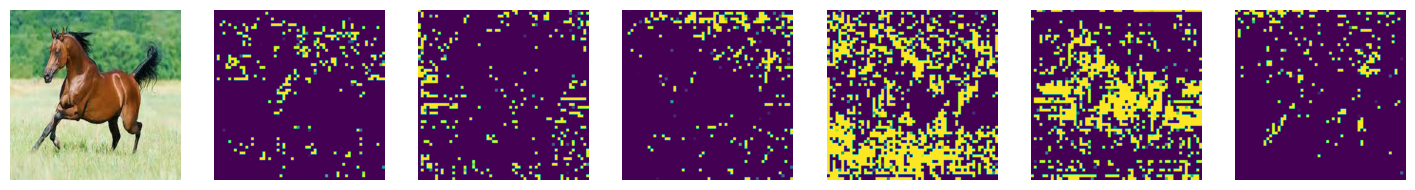

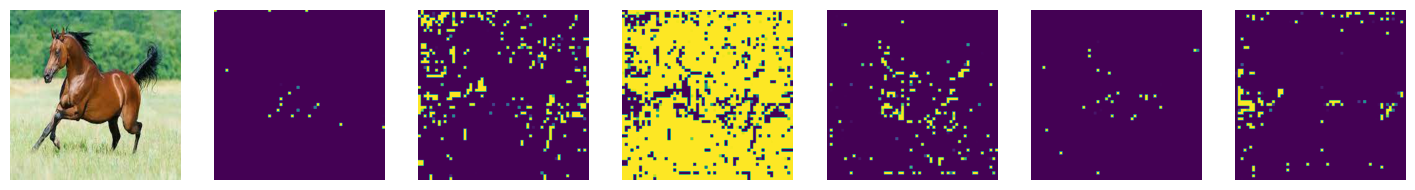

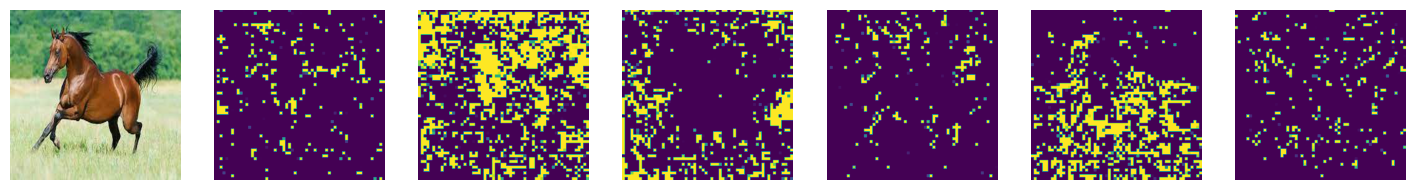

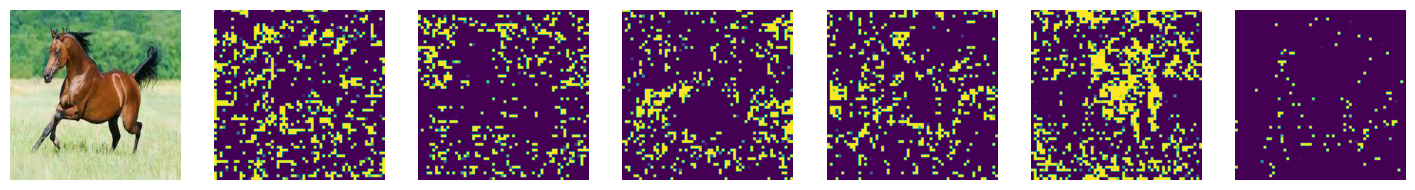

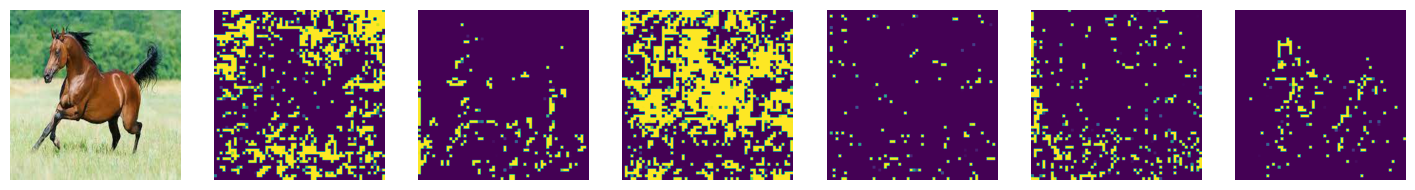

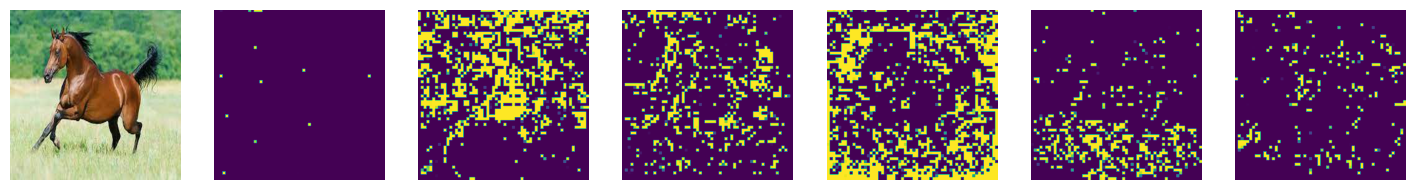

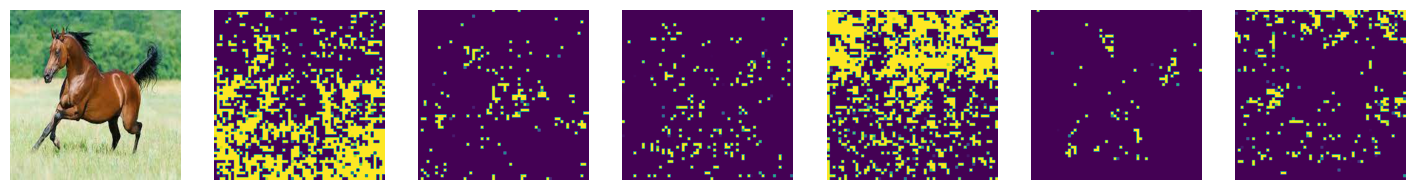

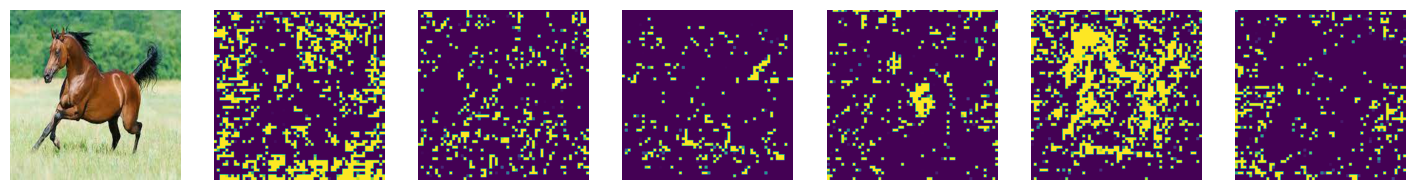

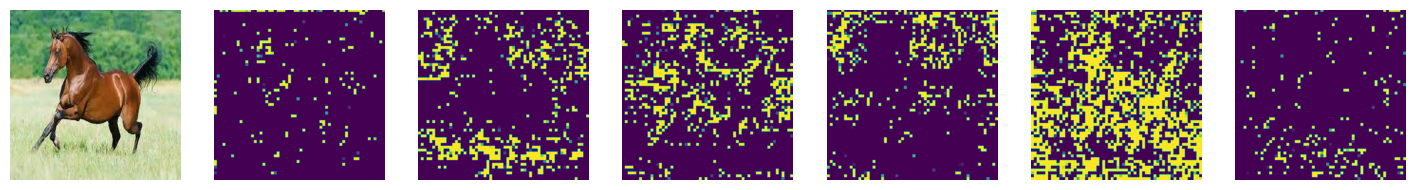

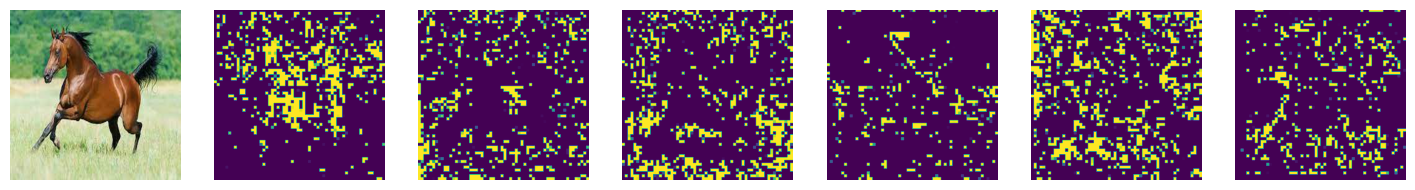

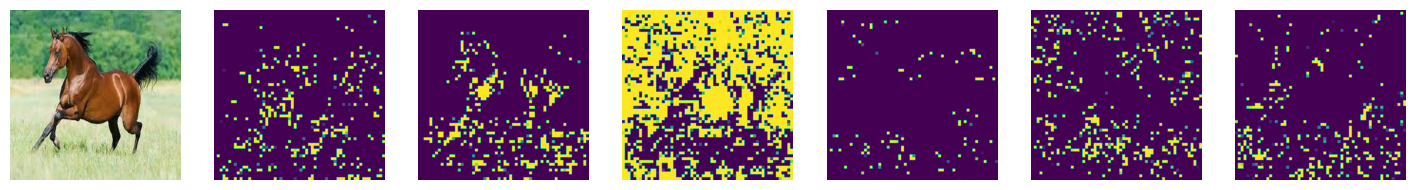

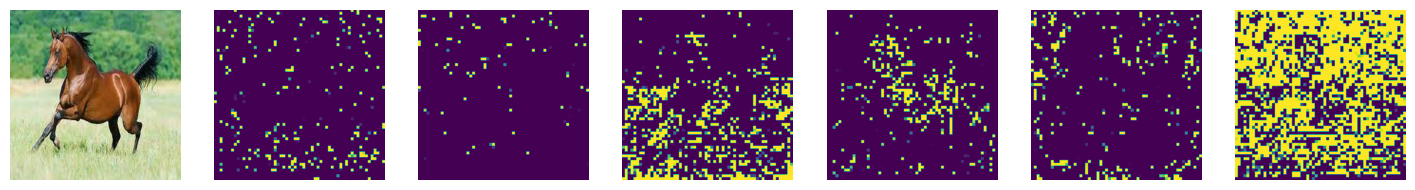

In [16]:
visual(model, img_dir, image_size, patch_size, layers=range(0, 12, 1))